# Sperimentazione di tecchine di apprendimento sul dataset Cora 

## informazioni sul dataset
Il dataset Cora è costituito da 2708 pubblicazioni scientifiche classificate in una delle sette classi. La rete di citazioni è composta da 5429 link. Ogni pubblicazione nel set di dati è descritta da un vettore di parole con valore 0/1 che indica l'assenza/presenza della parola corrispondente dal dizionario. Il dizionario è composto da 1433 parole uniche.


## importazionde delle librerie

In [110]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import numpy as np
import torch
import random
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm



import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold




# Caricamento del dataset in memoria e split in train/test

In [61]:
class MyDatasetLoader(InMemoryDataset):
    
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        #self.num_node_features=1433
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['cora.cites', 'cora.content']

    @property
    def processed_file_names(self):
        return ['cites.pt',"content.pt"]

    
    
    def download(self):
        pass

    def process(self): 
        feat_data, labels, edge_index, word_count, labels_count,label_map = self.load_cora_raw()
        edge_index= torch.tensor(edge_index)
        labels=  torch.tensor(labels, dtype=torch.long)
        num_nodes=2708
        feat_data=torch.tensor(feat_data,dtype=torch.float32)


        data = Data(x=feat_data,
                    edge_index=edge_index,
                    y=labels,
                    word_count=word_count,
                    labels_count=labels_count,
                    label_map=label_map)
        data.train_mask= torch.zeros([2708], dtype=torch.bool) 
        data.train_mask.fill_(True)
        data.test_mask= torch.zeros([2708], dtype=torch.bool) 
        data.test_mask.fill_(False)
        data.val_mask= torch.zeros([2708], dtype=torch.bool) 
        data.val_mask.fill_(False)
        random.seed(453)
        sampled_test = random.sample(range(num_nodes), int(num_nodes*0.20))
        data.train_mask[sampled_test]=False
        sampled_val=[]
        #data.x[sampled_test]= torch.zeros([1433], dtype=torch.float32)
        """for x in range(0,int(num_nodes*0.1)):
            num=sampled_test.pop()
            sampled_val.append(num)
        
        data.val_mask[sampled_val]=True """
        data.test_mask[sampled_test]=True
        

        data = data if self.pre_transform is None else self.pre_transform(data)
        
        torch.save(self.collate([data]), self.processed_paths[0])

    @staticmethod
    def load_cora_raw():
        word_count={}
        for x in range(0,1433):
            word_count[x]=0
        labels_count={}
        numero_nodi=2708
        numero_feature=1433
        feat_data = np.zeros((numero_nodi, numero_feature))
        labels = np.empty((numero_nodi), dtype=np.int32)
        node_map = {}
        label_map = {}
        with open("./dataset-raw/cora.content") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
            # print(info[1:-1])
                data =[]
                for x in info[1:-1]:
                    data.append(float(x))
                node_map[info[0]]=i
                feat_data[i,:] = data
                
                if not info[-1] in label_map:
                    label_map[info[-1]] = len(label_map)
                    labels_count[info[-1]]=1    

                labels_count[info[-1]]=labels_count[info[-1]]+1
                labels[i] = label_map[info[-1]]

                

                for i,val in enumerate(data):
                    word_count[i]=word_count[i]+val
        
        from collections import defaultdict
        adj_lists = defaultdict(set)
        edge_list1=[]
        edge_list2=[]
        with open("./dataset-raw/cora.cites") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
                paper1 = node_map[info[0]]
                paper2 = node_map[info[1]]

                edge_list1.append(paper1)
                edge_list1.append(paper2)
                edge_list2.append(paper2)
                edge_list2.append(paper1)


        return feat_data, labels , [edge_list1,edge_list2],word_count,labels_count,label_map





# funzioni utili

In [89]:
dict_valutazioni={}



dataset=MyDatasetLoader(root='./cora')
#reduce_dim_pca(dataset,100)
train_x= dataset[0].x[dataset[0].train_mask]
train_y= dataset[0].y[dataset[0].train_mask]
test_x = dataset[0].x[dataset[0].test_mask]
test_y = dataset[0].y[dataset[0].test_mask]





def reduce_dim_pca(dataset,reduce_dim_to):
    pca = PCA(n_components=reduce_dim_to)
    x= pca.fit_transform(dataset[0].x)
   
    dataset.data.x =torch.tensor(x,dtype=torch.float32)
    return 



def valutate_test(Y,Y_pred):
    acc=metrics.accuracy_score(Y, Y_pred)
    f=metrics.f1_score(Y, Y_pred,average='macro')
    confmatr=metrics.confusion_matrix(Y, Y_pred)
    return {'Accuracy':acc,"f1":f,"Confusion Matrix":confmatr}


def valutate_model_with_kfold(model,X,Y,n_splits):

    kfold = KFold(n_splits=n_splits, shuffle=True)

    train_x=X
    train_y=Y
    accuracy_list=[]
    f1_list=[]
    for train, test in kfold.split(train_x, train_y):
        
        model =model.fit(train_x[train],train_y[train])
        y_pred = model.predict(train_x[test])
        accuracy=metrics.accuracy_score(train_y[test], y_pred)
        f1=metrics.f1_score(train_y[test], y_pred,average='macro')
        accuracy_list.append(accuracy)
        f1_list.append(f1)

    accuracy=sum(accuracy_list)/len(accuracy_list)
    f1=sum(f1_list)/len(f1_list)
    return {"accuracy":accuracy,"f1":f1}


# Statistiche sul dataset 

In [76]:
dataset=MyDatasetLoader(root='./cora')
train_y= dataset[0].y[dataset[0].train_mask]
test_y = dataset[0].y[dataset[0].test_mask]
train_x=dataset[0].x[dataset[0].train_mask]
test_x=dataset[0].x[dataset[0].test_mask]
word_count=dataset[0].word_count

Processing...
Done!


## Heat map delle feature rispetto alle classi
    Asse y -> features
    Asse x -> classi

    0 -> Neural_Networks \
    1 -> Rule_Learning \
    2 -> Reinforcement_Learning \ 
    3 -> Probabilistic_Methods \
    4 -> Theory \
    5 -> Genetic_Algorithms \
    6 -> Case_Based 

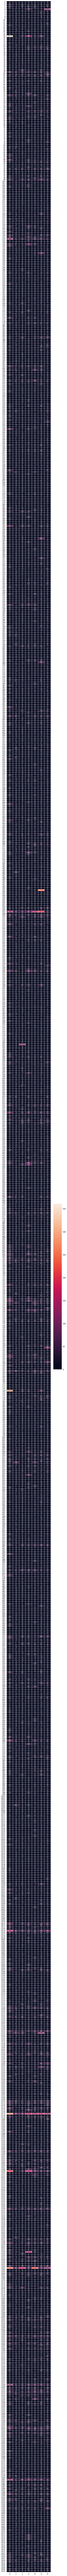

In [77]:
matrix=np.zeros((len(dataset[0].x[0]),7))
for element,label in zip(dataset[0].x,dataset[0].y):
    for feature,index in zip(element,range(0,len(element))):
        matrix[index][label]=matrix[index][label]+feature

matrice=matrix
#matrix[matrix==0.0]=np.nan
plt.figure(figsize = (6,0.2*len(matrice)))
sns.heatmap(matrice, annot=True, linewidths=.5)
plt.show()

## Grafico a barre del numero di volte che ogni parola appare in tutti i documenti 

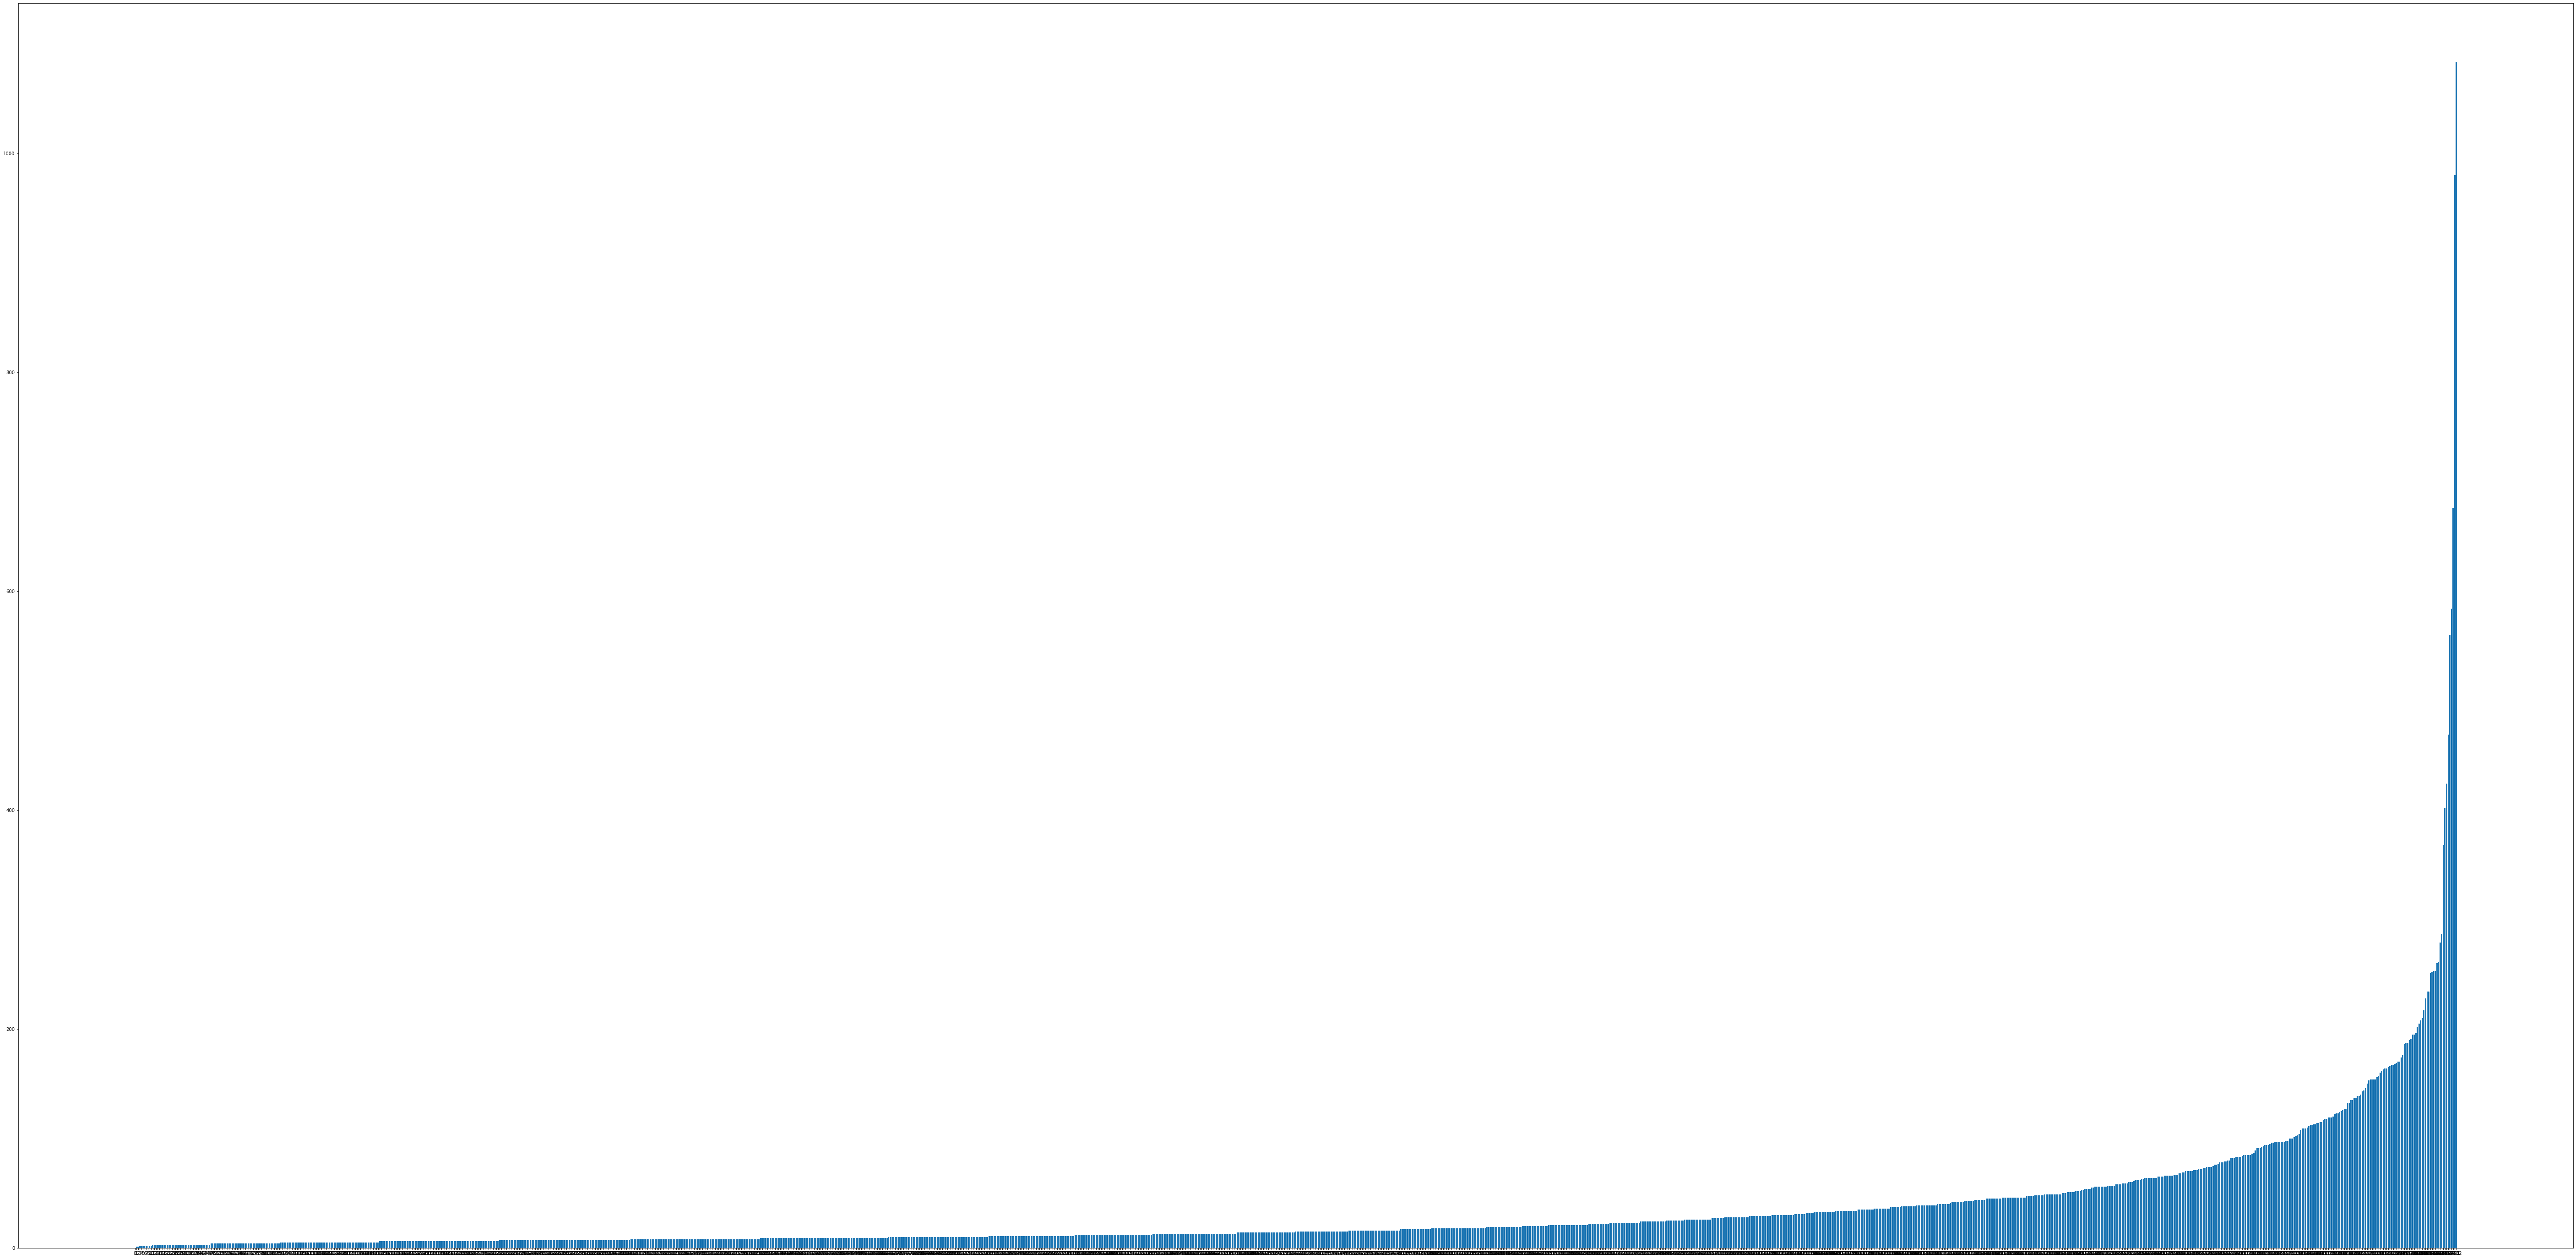

occorrenza massima:  1083.0
occorrenza minima:   0.0
occorenza media:     34.34473133286811


In [78]:

plt.figure(figsize = (100, 50))
plt.bar(range(len(word_count)), sorted(list(word_count.values())), align='center')
plt.xticks(range(len(word_count)), list(word_count.keys()))
plt.show()
def avg(lst):
    return sum(lst) / len(lst)
print("occorrenza massima: ",max(list(word_count.values())))
print("occorrenza minima:  ",min(list(word_count.values())))
print("occorenza media:    ",avg(list(word_count.values())))

## Numero di documenti per etichetta

### Numero di documenti per etichetta su tutto il dataset

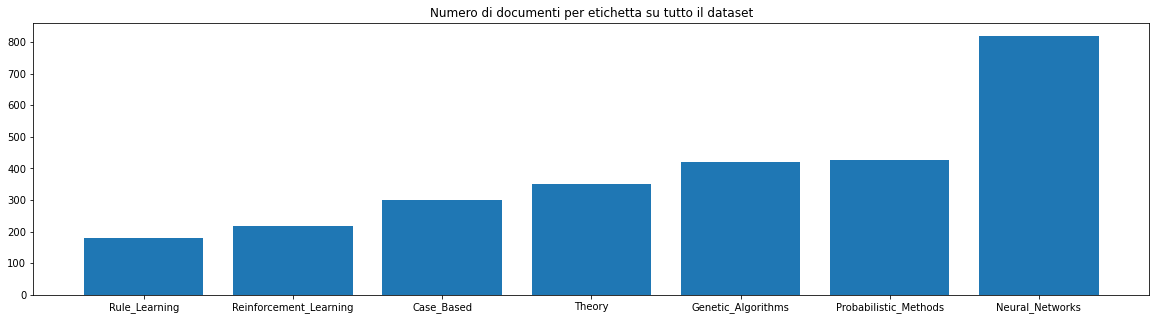

In [79]:
labels_count=dataset[0].labels_count
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta su tutto il dataset')
plt.show()

### Numero di documenti per etichetta sul training set

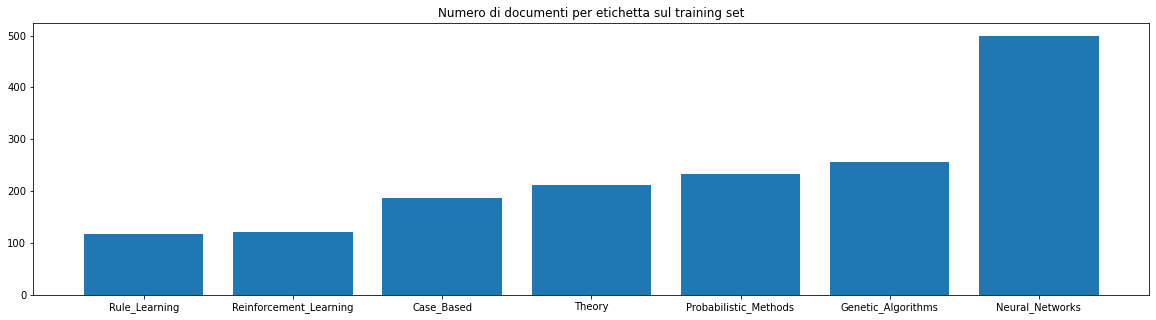

In [10]:
label_map=inv_map = {dataset.data.label_map[k] : k for k in dataset.data.label_map}
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in train_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul training set')
plt.show()

### Numero di documenti per etichetta sul test set

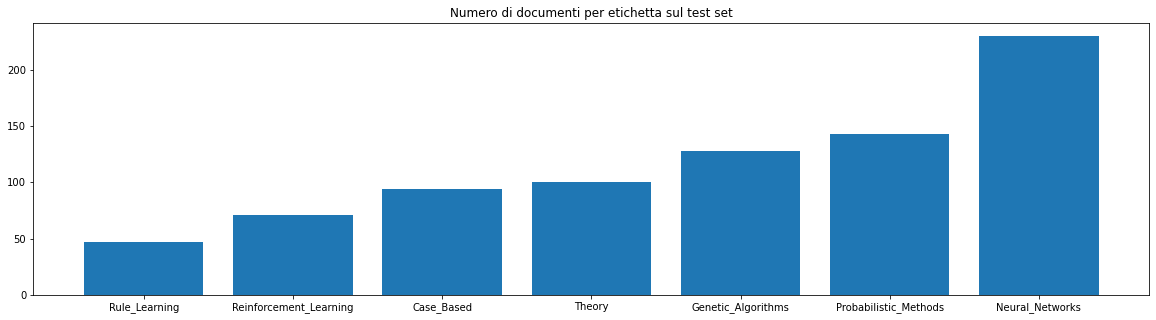

In [11]:
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in test_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul test set')
plt.show()

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


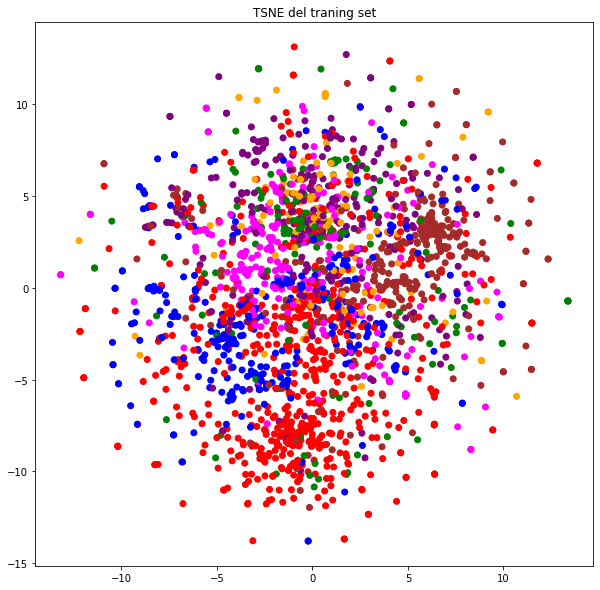

In [80]:
color_list = ["red", "orange", "green", "blue", "purple", "brown","fuchsia"]
colors_train = []
colors_train +=  [color_list[y] for y in dataset[0].y[dataset[0].train_mask]]
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

xs_tsne, ys_tsne = zip(*TSNE(learning_rate='auto',init='pca').fit_transform(dataset[0].x))
xs_tsne= torch.Tensor(xs_tsne)
ys_tsne= torch.Tensor(ys_tsne)

xs_tsne_train = xs_tsne[dataset[0].train_mask]
ys_tsne_train = ys_tsne[dataset[0].train_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del traning set")
plt.scatter(xs_tsne_train, ys_tsne_train, color=colors_train)

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


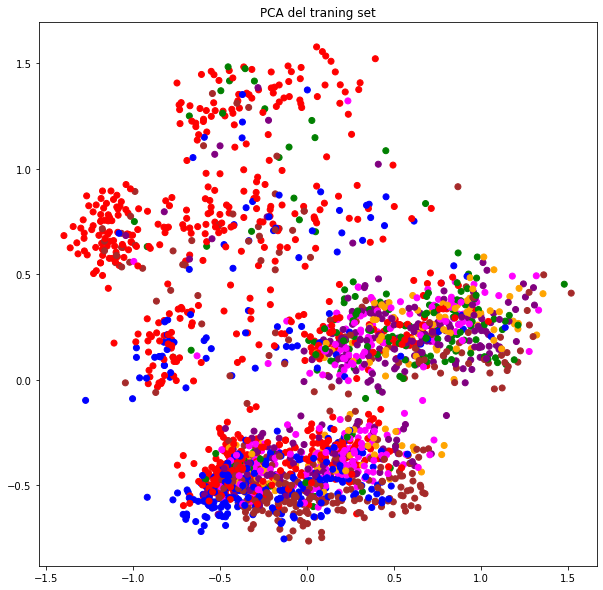

In [81]:
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

pca = PCA(n_components=2)
principalComponents = pca.fit_transform( dataset[0].x)
xs_pca,ys_pca=zip(*principalComponents)
xs_pca= torch.Tensor(xs_pca)
ys_pca= torch.Tensor(ys_pca)
xs_pca_train = xs_pca[dataset[0].train_mask]
ys_pca_train = ys_pca[dataset[0].train_mask]

plt.figure(figsize = (10, 10))
plt.title("PCA del traning set")
plt.scatter(xs_pca_train, ys_pca_train, color=colors_train)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

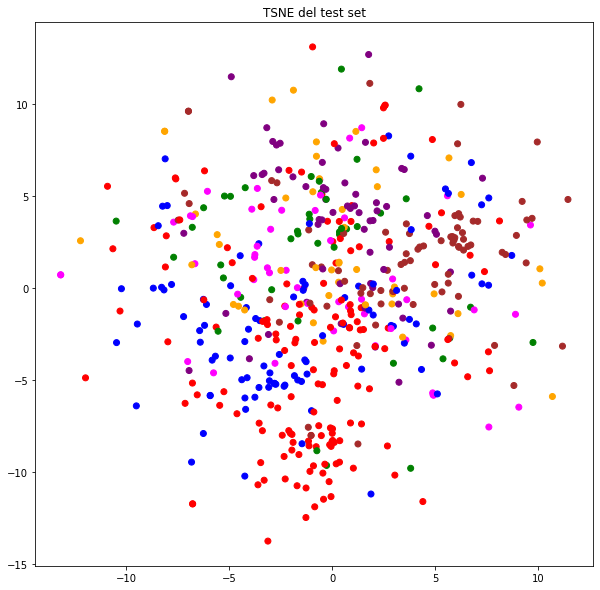

In [82]:
colors_test=[]
colors_test +=  [color_list[y] for y in test_y]
xs_tsne_test=xs_tsne[dataset[0].test_mask]
ys_tsne_test=ys_tsne[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del test set")
plt.scatter(xs_tsne_test, ys_tsne_test, color=colors_test)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

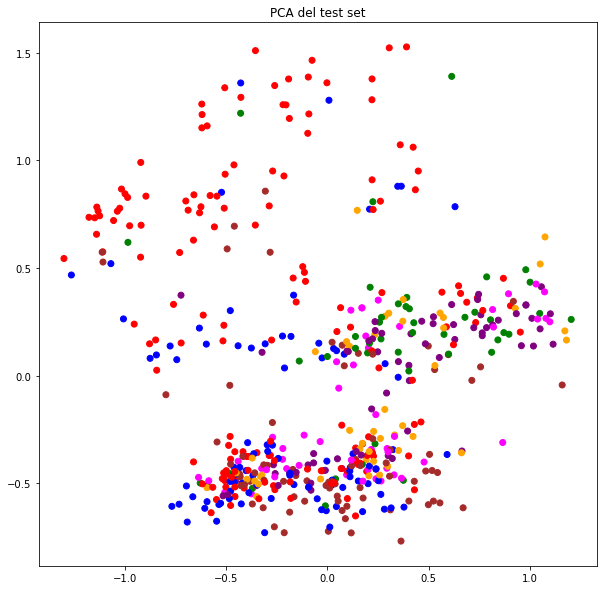

In [87]:
xs_pca_test=xs_pca[dataset[0].test_mask]
ys_pca_test=ys_pca[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("PCA del test set")
plt.scatter(xs_pca_test, ys_pca_test, color=colors_test)

# Logistic regression

In [100]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['LogisticRegression']={"test":test_valutation,"kfold":cros_valutation}


valutazione con test 20% {'Accuracy': 0.7541589648798521, 'f1': 0.7303697637390734, 'Confusion Matrix': array([[134,   3,   0,   5,  13,   2,   2],
       [  8,  23,   0,   2,   8,   1,   4],
       [  8,   0,  29,   1,   3,   2,   1],
       [ 16,   1,   1,  70,   1,   0,   4],
       [  3,   1,   1,   4,  51,   3,   2],
       [  8,   0,   1,   0,   2,  70,   2],
       [  5,   1,   1,   3,   8,   2,  31]], dtype=int64)}
[[134   3   0   5  13   2   2]
 [  8  23   0   2   8   1   4]
 [  8   0  29   1   3   2   1]
 [ 16   1   1  70   1   0   4]
 [  3   1   1   4  51   3   2]
 [  8   0   1   0   2  70   2]
 [  5   1   1   3   8   2  31]]
valutazione con 5 fold {'accuracy': 0.7599764001336872, 'f1': 0.7378265286042973}


# Linear Discriminant Analysis

In [98]:


model = LinearDiscriminantAnalysis(store_covariance=True)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation,"kfold":cros_valutation}


Processing...
Done!


valutazione con test 20% {'Accuracy': 0.5804066543438078, 'f1': 0.562820076887256, 'Confusion Matrix': array([[94,  5,  9, 15, 25,  6,  5],
       [10, 15,  1,  3,  8,  3,  6],
       [ 6,  0, 27,  3,  3,  4,  1],
       [17,  2,  3, 59,  6,  2,  4],
       [ 7,  4,  1,  6, 41,  4,  2],
       [15,  1,  3,  6,  3, 51,  4],
       [ 8,  2,  2,  2,  8,  2, 27]], dtype=int64)}
[[94  5  9 15 25  6  5]
 [10 15  1  3  8  3  6]
 [ 6  0 27  3  3  4  1]
 [17  2  3 59  6  2  4]
 [ 7  4  1  6 41  4  2]
 [15  1  3  6  3 51  4]
 [ 8  2  2  2  8  2 27]]
valutazione con 5 fold {'accuracy': 0.6026730600023191, 'f1': 0.5901038146745956}


# Quadratic Discriminant Analysis

In [101]:
model = QuadraticDiscriminantAnalysis(store_covariance=True)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation,"kfold":cros_valutation}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear

valutazione con test 20% {'Accuracy': 0.12014787430683918, 'f1': 0.030645921735030644, 'Confusion Matrix': array([[  0,   0,   0,   0, 159,   0,   0],
       [  0,   0,   0,   0,  46,   0,   0],
       [  0,   0,   0,   0,  44,   0,   0],
       [  0,   0,   0,   0,  93,   0,   0],
       [  0,   0,   0,   0,  65,   0,   0],
       [  0,   0,   0,   0,  83,   0,   0],
       [  0,   0,   0,   0,  51,   0,   0]], dtype=int64)}
[[  0   0   0   0 159   0   0]
 [  0   0   0   0  46   0   0]
 [  0   0   0   0  44   0   0]
 [  0   0   0   0  93   0   0]
 [  0   0   0   0  65   0   0]
 [  0   0   0   0  83   0   0]
 [  0   0   0   0  51   0   0]]
valutazione con 5 fold {'accuracy': 0.12260266964961701, 'f1': 0.056537524461058475}


# K Neighbors Classifier

In [104]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation,"kfold":cros_valutation}


valutazione con test 20% {'Accuracy': 0.45286506469500926, 'f1': 0.39324570937732706, 'Confusion Matrix': array([[101,   5,   8,  17,   6,  21,   1],
       [ 19,   9,   4,   5,   7,   2,   0],
       [ 19,   4,  10,   4,   4,   3,   0],
       [ 27,   4,   0,  45,   9,   6,   2],
       [ 19,  13,   3,   6,  21,   2,   1],
       [ 17,   3,  10,   2,   4,  47,   0],
       [ 15,   5,   5,   9,   4,   1,  12]], dtype=int64)}
[[101   5   8  17   6  21   1]
 [ 19   9   4   5   7   2   0]
 [ 19   4  10   4   4   3   0]
 [ 27   4   0  45   9   6   2]
 [ 19  13   3   6  21   2   1]
 [ 17   3  10   2   4  47   0]
 [ 15   5   5   9   4   1  12]]
valutazione con 5 fold {'accuracy': 0.45089659029677176, 'f1': 0.376960552732036}


# Train Decision Tree Classifer

In [107]:
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation,"kfold":cros_valutation}

valutazione con test 20% {'Accuracy': 0.6506469500924215, 'f1': 0.6286072257712542, 'Confusion Matrix': array([[115,   1,   3,  16,  14,   6,   4],
       [  4,  22,   1,   3,   6,   5,   5],
       [  2,   3,  23,   4,   6,   3,   3],
       [ 20,   3,   0,  60,   5,   2,   3],
       [ 13,   2,   1,   3,  39,   4,   3],
       [ 11,   0,   1,   0,   4,  64,   3],
       [  7,   3,   0,   2,   8,   2,  29]], dtype=int64)}
[[115   1   3  16  14   6   4]
 [  4  22   1   3   6   5   5]
 [  2   3  23   4   6   3   3]
 [ 20   3   0  60   5   2   3]
 [ 13   2   1   3  39   4   3]
 [ 11   0   1   0   4  64   3]
 [  7   3   0   2   8   2  29]]
valutazione con 5 fold {'accuracy': 0.6495494881011658, 'f1': 0.6249836653756595}


# Random Forest Classifier

In [108]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['RandomForestClassifier']={"test":test_valutation,"kfold":cros_valutation}

valutazione con test 20% {'Accuracy': 0.7393715341959335, 'f1': 0.7234770807946409, 'Confusion Matrix': array([[134,   0,   0,   7,  13,   4,   1],
       [ 12,  24,   0,   2,   5,   1,   2],
       [  9,   0,  27,   4,   2,   2,   0],
       [ 12,   2,   1,  69,   1,   1,   7],
       [ 10,   1,   0,   4,  44,   3,   3],
       [ 10,   0,   0,   0,   2,  69,   2],
       [  6,   0,   0,   2,  10,   0,  33]], dtype=int64)}
[[134   0   0   7  13   4   1]
 [ 12  24   0   2   5   1   2]
 [  9   0  27   4   2   2   0]
 [ 12   2   1  69   1   1   7]
 [ 10   1   0   4  44   3   3]
 [ 10   0   0   0   2  69   2]
 [  6   0   0   2  10   0  33]]
valutazione con 5 fold {'accuracy': 0.7596039860583449, 'f1': 0.7379698645214111}


# Support Vector Machines

## SVM kernel linear 

In [111]:
model = svm.SVC(kernel='linear')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['svmLinear']={"test":test_valutation,"kfold":cros_valutation}

valutazione con test 20% {'Accuracy': 0.7153419593345656, 'f1': 0.6992698521717441, 'Confusion Matrix': array([[123,   3,   1,  10,  14,   4,   4],
       [  7,  26,   2,   1,   5,   0,   5],
       [  6,   0,  31,   3,   2,   2,   0],
       [ 15,   1,   2,  70,   2,   1,   2],
       [  8,   3,   1,   5,  43,   1,   4],
       [  9,   0,   2,   2,   3,  64,   3],
       [  5,   1,   3,   6,   6,   0,  30]], dtype=int64)}
[[123   3   1  10  14   4   4]
 [  7  26   2   1   5   0   5]
 [  6   0  31   3   2   2   0]
 [ 15   1   2  70   2   1   2]
 [  8   3   1   5  43   1   4]
 [  9   0   2   2   3  64   3]
 [  5   1   3   6   6   0  30]]
valutazione con 5 fold {'accuracy': 0.7200974006043204, 'f1': 0.6937869078555814}


## SVM kernel poly

In [112]:
model = svm.SVC(kernel='poly')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['svmPoly']={"test":test_valutation,"kfold":cros_valutation}

valutazione con test 20% {'Accuracy': 0.4066543438077634, 'f1': 0.2878444574845688, 'Confusion Matrix': array([[159,   0,   0,   0,   0,   0,   0],
       [ 43,   3,   0,   0,   0,   0,   0],
       [ 40,   0,   3,   0,   0,   1,   0],
       [ 77,   0,   0,  16,   0,   0,   0],
       [ 55,   0,   0,   1,   9,   0,   0],
       [ 65,   0,   0,   0,   0,  18,   0],
       [ 38,   0,   0,   0,   1,   0,  12]], dtype=int64)}
[[159   0   0   0   0   0   0]
 [ 43   3   0   0   0   0   0]
 [ 40   0   3   0   0   1   0]
 [ 77   0   0  16   0   0   0]
 [ 55   0   0   1   9   0   0]
 [ 65   0   0   0   0  18   0]
 [ 38   0   0   0   1   0  12]]
valutazione con 5 fold {'accuracy': 0.41506776435601694, 'f1': 0.29038818794577353}


## SVM kernel rbf 

In [113]:
model = svm.SVC(kernel='rbf')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
print("valutazione con 5 fold",cros_valutation)
dict_valutazioni['svmRbf']={"test":test_valutation,"kfold":cros_valutation}

valutazione con test 20% {'Accuracy': 0.7264325323475046, 'f1': 0.7028348926218905, 'Confusion Matrix': array([[142,   0,   0,   6,  10,   1,   0],
       [ 14,  18,   0,   0,  11,   0,   3],
       [ 12,   0,  27,   1,   3,   1,   0],
       [ 21,   0,   0,  70,   1,   0,   1],
       [ 15,   1,   0,   4,  41,   1,   3],
       [ 12,   0,   1,   0,   2,  67,   1],
       [ 10,   1,   0,   2,   9,   1,  28]], dtype=int64)}
[[142   0   0   6  10   1   0]
 [ 14  18   0   0  11   0   3]
 [ 12   0  27   1   3   1   0]
 [ 21   0   0  70   1   0   1]
 [ 15   1   0   4  41   1   3]
 [ 12   0   1   0   2  67   1]
 [ 10   1   0   2   9   1  28]]
valutazione con 5 fold {'accuracy': 0.7511080341857023, 'f1': 0.7309560798591676}
